In [23]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, 
                          Dropout, BatchNormalization, Activation, Add)
from keras import optimizers

from tqdm import tqdm_notebook, tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from image_processing import upsample, downsample
from data import prepare_data, test_images_path,load_images_as_arrays
import os
from visualisation import (plot_coverage_and_coverage_class, 
                           scatter_coverage_and_coverage_class,
                           plot_depth_distributions,
                           plot_predictions,
                           plot_images)
from model import model_path
from metrics import iou_metric_batch, my_iou_metric, my_iou_metric_2
from toolz import compose
from data import run_length_encode, rle_encode
import datetime
from losses import lovasz_loss

In [4]:
train_df, test_df = prepare_data()

100%|██████████| 4000/4000 [00:01<00:00, 2635.73it/s]


In [5]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


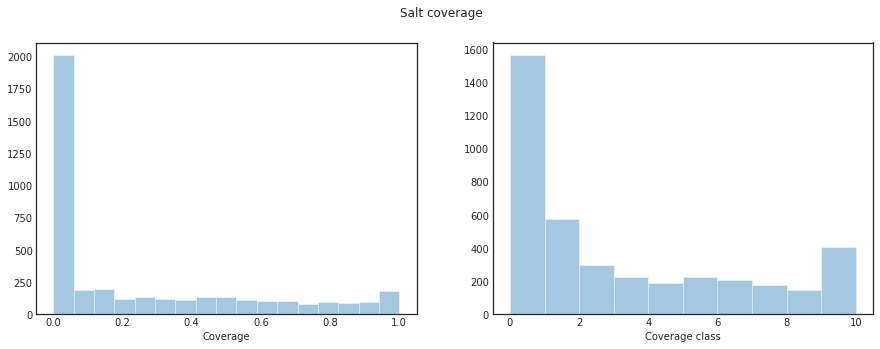

In [6]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

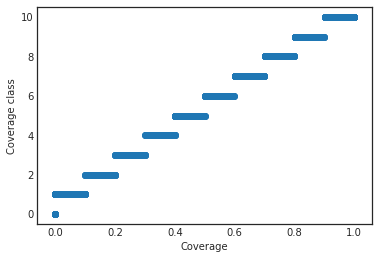

In [7]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

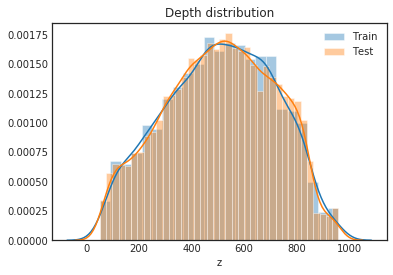

In [8]:
plot_depth_distributions(train_df.z, test_df.z)

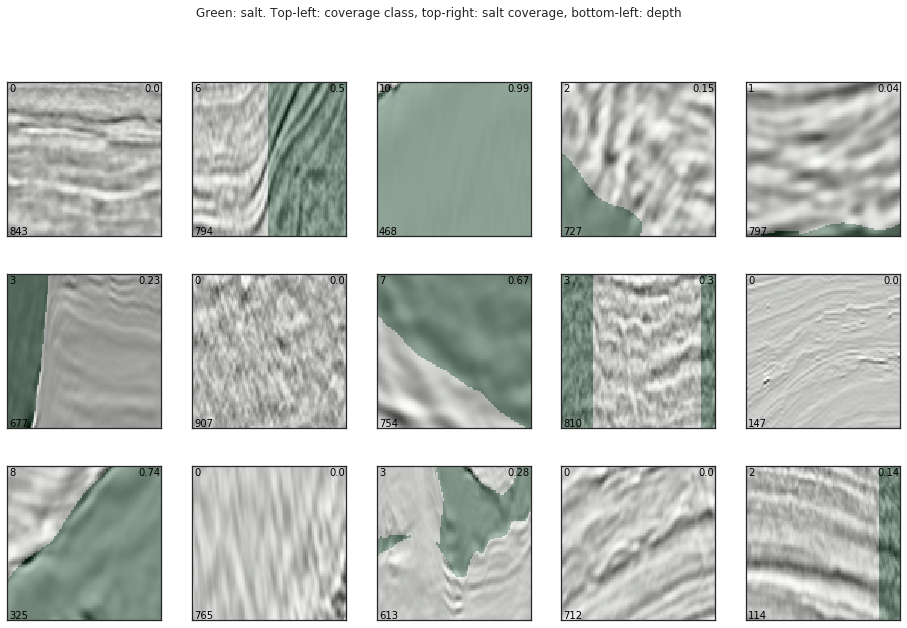

In [9]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16,10))

In [11]:
img_size_target=101

In [12]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [13]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [14]:
def build_model(input_layer, start_neurons, dropout_ratio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout_ratio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout_ratio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout_ratio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_ratio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_ratio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_ratio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(dropout_ratio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(dropout_ratio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [20]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, dropout_ratio=0.5)

In [21]:
model = Model(input_layer, output_layer)

In [24]:
c = optimizers.adam(lr = 0.01)
model.compile(loss="binary_crossentropy", optimizer=c, metrics=["accuracy", my_iou_metric])

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 101, 101, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 101, 101, 16) 64          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_4 (

In [26]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [27]:
model_filepath=os.path.join(model_path(), 'stage1_keras.model')
model_checkpoint = ModelCheckpoint(model_filepath, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 60
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr],
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/60
 - 34s - loss: 0.4033 - acc: 0.8260 - my_iou_metric: 0.3770 - val_loss: 0.5664 - val_acc: 0.7583 - val_my_iou_metric: 0.3791

Epoch 00001: my_iou_metric improved from -inf to 0.37700, saving model to /mnt/models/unet_resnet/stage1_keras.model
Epoch 2/60
 - 20s - loss: 0.3484 - acc: 0.8609 - my_iou_metric: 0.5012 - val_loss: 0.4271 - val_acc: 0.8261 - val_my_iou_metric: 0.4624

Epoch 00002: my_iou_metric improved from 0.37700 to 0.50123, saving model to /mnt/models/unet_resnet/stage1_keras.model
Epoch 3/60
 - 20s - loss: 0.3115 - acc: 0.8788 - my_iou_metric: 0.5310 - val_loss: 0.8380 - val_acc: 0.7521 - val_my_iou_metric: 0.3759

Epoch 00003: my_iou_metric improved from 0.50123 to 0.53098, saving model to /mnt/models/unet_resnet/stage1_keras.model
Epoch 4/60
 - 20s - loss: 0.2642 - acc: 0.8979 - my_iou_metric: 0.5677 - val_loss: 0.4804 - val_acc: 0.8428 - val_my_iou_metric: 0.4909

Epoch 00004: my_iou_metric improved from 0.53098


Epoch 00034: my_iou_metric did not improve from 0.73169
Epoch 35/60
 - 20s - loss: 0.1186 - acc: 0.9538 - my_iou_metric: 0.7364 - val_loss: 0.1393 - val_acc: 0.9451 - val_my_iou_metric: 0.7339

Epoch 00035: my_iou_metric improved from 0.73169 to 0.73636, saving model to /mnt/models/unet_resnet/stage1_keras.model
Epoch 36/60
 - 20s - loss: 0.1180 - acc: 0.9559 - my_iou_metric: 0.7412 - val_loss: 0.1432 - val_acc: 0.9473 - val_my_iou_metric: 0.7640

Epoch 00036: my_iou_metric improved from 0.73636 to 0.74117, saving model to /mnt/models/unet_resnet/stage1_keras.model
Epoch 37/60
 - 20s - loss: 0.1295 - acc: 0.9514 - my_iou_metric: 0.7315 - val_loss: 0.1875 - val_acc: 0.9327 - val_my_iou_metric: 0.6363

Epoch 00037: my_iou_metric did not improve from 0.74117
Epoch 38/60
 - 20s - loss: 0.1196 - acc: 0.9551 - my_iou_metric: 0.7381 - val_loss: 0.1399 - val_acc: 0.9462 - val_my_iou_metric: 0.7526

Epoch 00038: my_iou_metric did not improve from 0.74117
Epoch 39/60
 - 20s - loss: 0.1134 - acc

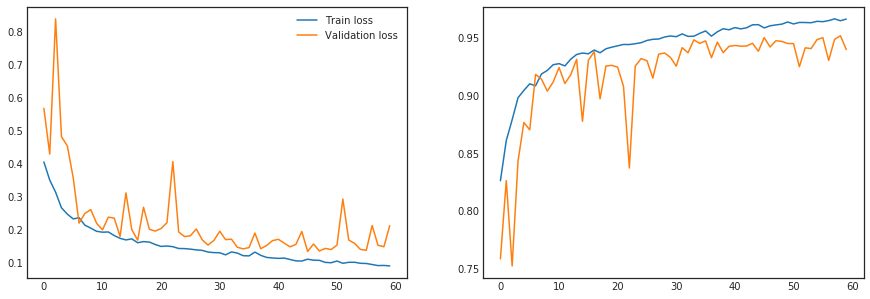

In [28]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_loss.legend()

In [29]:
model_stage1 = load_model(model_filepath, custom_objects={'my_iou_metric': my_iou_metric})

In [31]:
input_x = model_stage1.layers[0].input

output_layer = model_stage1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

In [32]:
model_filepath=os.path.join(model_path(), 'stage2_keras.model')
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', 
                               mode = 'max', 
                               patience=20, 
                               verbose=1)
model_checkpoint = ModelCheckpoint(model_filepath,
                                   monitor='val_my_iou_metric_2', 
                                   mode = 'max', 
                                   save_best_only=True, 
                                   verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', 
                              mode = 'max',
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=1)
epochs = 50
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/50
 - 81s - loss: 0.4126 - my_iou_metric_2: 0.7888 - val_loss: 0.4915 - val_my_iou_metric_2: 0.7528

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.75275, saving model to /mnt/models/unet_resnet/stage2_keras.model
Epoch 2/50
 - 64s - loss: 0.3711 - my_iou_metric_2: 0.7960 - val_loss: 0.5062 - val_my_iou_metric_2: 0.7521

Epoch 00002: val_my_iou_metric_2 did not improve from 0.75275
Epoch 3/50
 - 64s - loss: 0.3684 - my_iou_metric_2: 0.7930 - val_loss: 0.4038 - val_my_iou_metric_2: 0.7738

Epoch 00003: val_my_iou_metric_2 improved from 0.75275 to 0.77375, saving model to /mnt/models/unet_resnet/stage2_keras.model
Epoch 4/50
 - 64s - loss: 0.3610 - my_iou_metric_2: 0.7954 - val_loss: 0.3948 - val_my_iou_metric_2: 0.7719

Epoch 00004: val_my_iou_metric_2 did not improve from 0.77375
Epoch 5/50
 - 64s - loss: 0.3638 - my_iou_metric_2: 0.7916 - val_loss: 0.4684 - val_my_iou_metric_2: 0.7398

Epoch 00005: val_my_iou_metric_2 di


Epoch 00042: val_my_iou_metric_2 did not improve from 0.81088
Epoch 43/50
 - 64s - loss: 0.2619 - my_iou_metric_2: 0.8393 - val_loss: 0.3319 - val_my_iou_metric_2: 0.8059

Epoch 00043: val_my_iou_metric_2 did not improve from 0.81088

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 44/50
 - 64s - loss: 0.2672 - my_iou_metric_2: 0.8359 - val_loss: 0.3289 - val_my_iou_metric_2: 0.8057

Epoch 00044: val_my_iou_metric_2 did not improve from 0.81088
Epoch 45/50
 - 64s - loss: 0.2616 - my_iou_metric_2: 0.8395 - val_loss: 0.3282 - val_my_iou_metric_2: 0.8058

Epoch 00045: val_my_iou_metric_2 did not improve from 0.81088
Epoch 46/50
 - 64s - loss: 0.2653 - my_iou_metric_2: 0.8384 - val_loss: 0.3290 - val_my_iou_metric_2: 0.8046

Epoch 00046: val_my_iou_metric_2 did not improve from 0.81088
Epoch 47/50
 - 64s - loss: 0.2598 - my_iou_metric_2: 0.8395 - val_loss: 0.3332 - val_my_iou_metric_2: 0.8055

Epoch 00047: val_my_iou_metric_2 did not improve from 0.81

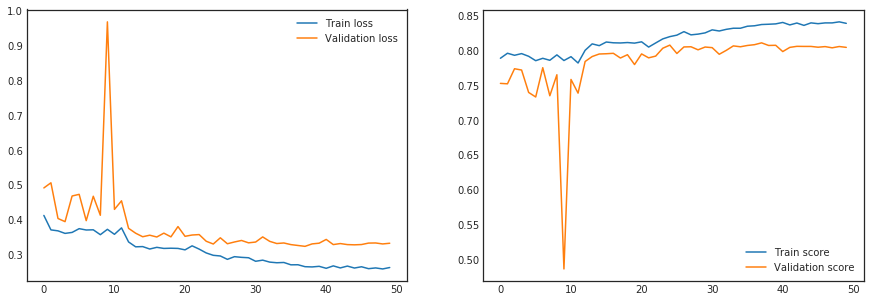

In [33]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [34]:
model = load_model(model_filepath,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [35]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [36]:
# downsample128to101 = downsample(128,101)

In [37]:
preds_valid = predict_result(model,x_valid,101)

In [20]:
# preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
# preds_valid = np.array([downsample128to101(x) for x in preds_valid])
# y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

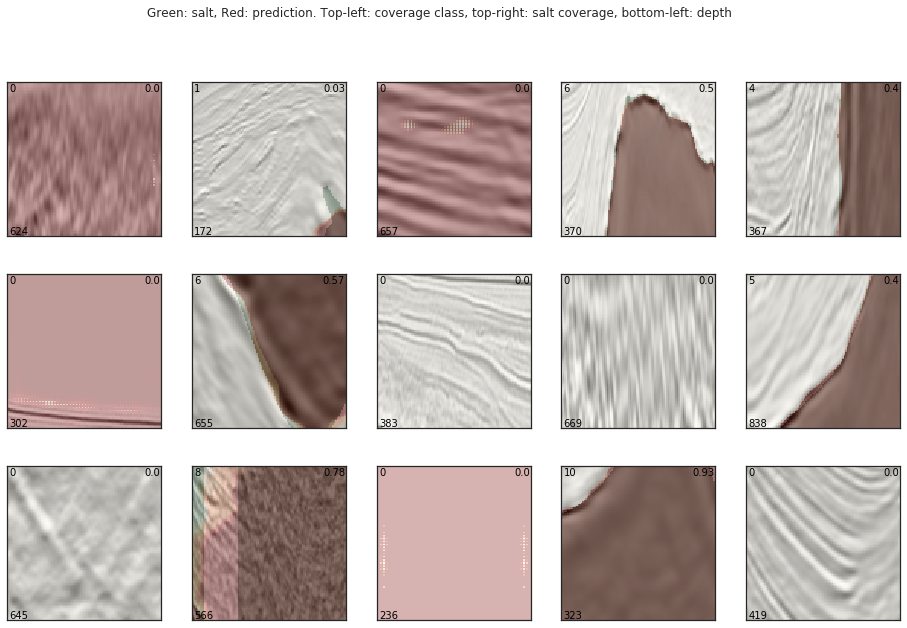

In [38]:
plot_predictions(train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [39]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

ious = list(map(lambda th: iou_metric_batch(preds_valid , np.int32(preds_valid > th)), 
                tqdm(thresholds)))

100%|██████████| 31/31 [00:41<00:00,  1.35s/it]


In [40]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

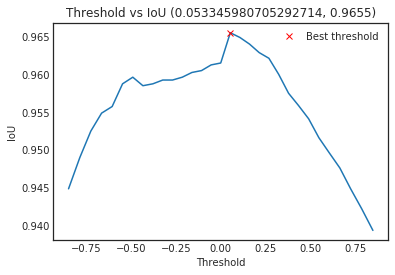

In [41]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [42]:
preds_thresh = list(map(lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32), preds_valid))

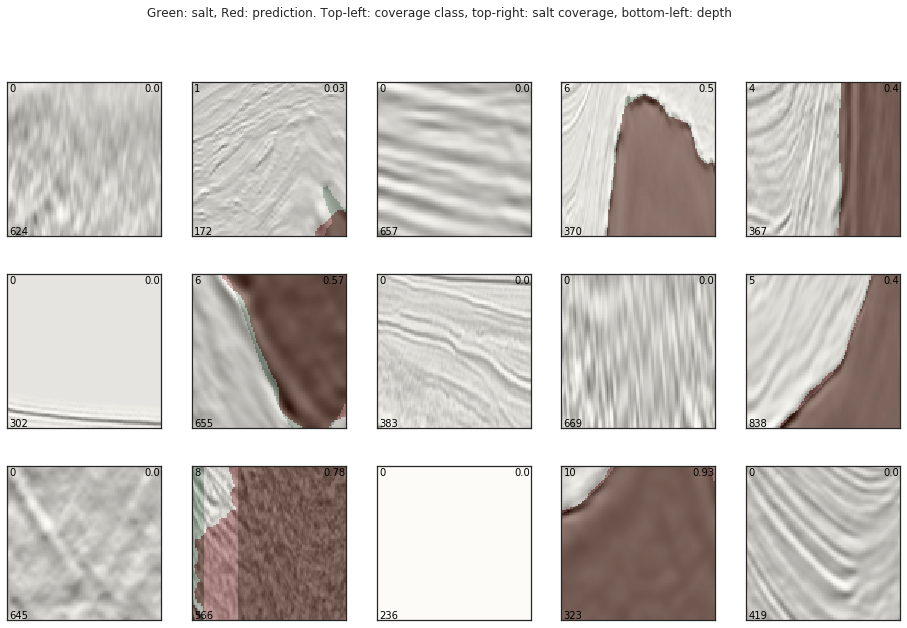

In [43]:
plot_predictions(train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [46]:
# img_size_target=101
x_test = load_images_as_arrays(test_df.index, test_images_path())
x_test = np.array(x_test)

100%|██████████| 18000/18000 [00:14<00:00, 1240.18it/s]


In [47]:
x_test = x_test.reshape(-1, img_size_target, img_size_target, 1)

In [48]:
preds_test = predict_result(model,x_test,101)

In [53]:
transform = compose(rle_encode, 
                    np.round,
                    lambda x: x > threshold_best)

In [54]:
pred_dict = {idx: transform(preds_test[i]) for i, idx in enumerate(tqdm(test_df.index.values))}

100%|██████████| 18000/18000 [00:05<00:00, 3216.42it/s]


In [51]:
now = datetime.datetime.now()

In [52]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
filename=os.path.join(model_path(),f"submission_{now:%d%b%Y_%H}.csv")
sub.to_csv(filename)